# BiciMAD - Machine learning predictions

Copyright © 2017 Javi Ramírez <javi.rmrz@gmail.com> | [@rameerez [tw]](http://twitter.com/rameerez) | [GitHub](http://github.com/rameerez)

This code is Open Source, released under the MIT License.

## Why/what
We've studied the actual BiciMAD users' behavior in other notebooks – but can we predict user behavior using Artificial Intelligence?

## Definitions

In [2]:
# Data describing all bike rides
BIKE_RIDES_DATASET = './data/export_20170301_20170406.json'
# Data describing all stations (used just for getting stations' coordinates & names)
STATIONS_DATASET = './data/stations.json'

In [12]:
%matplotlib inline
import pandas as pd
import numpy as np
import math
import dateutil.parser
from pandas.io.json import json_normalize

In [4]:
import tflearn

In [5]:
df = pd.read_json(BIKE_RIDES_DATASET, lines=True)

In [6]:
df[:3]

,_id,ageRange,idplug_base,idplug_station,idunplug_base,idunplug_station,track,travel_time,unplug_hourTime,user_day_code,user_type,zip_code
0,{'$oid': '58d1b3dd865e9c30d0b83c6f'},4,4,17,5,14,NaN,2303,{'$date': '2017-03-01T00:00:00.000+0100'},cc6d426ada96494d8dfe0fe0af512599f439cd9413d50c...,1,28012
1,{'$oid': '58d1b3dc865e9c30d0b83c6c'},4,2,76,22,123,NaN,876,{'$date': '2017-03-01T00:00:00.000+0100'},a81b44c3fe3c2f1e4bf723d228a0d025962228179c2e4d...,1,28009
2,{'$oid': '58d1b3dc865e9c30d0b83c6a'},5,16,163,19,166,NaN,483,{'$date': '2017-03-01T00:00:00.000+0100'},b20f0b657c493842b0aa5ebd32eed5d940c699715ee8bc...,1,28010


## Converting unplug time JSON to valid Datetime
Unfortunately the `unplug_hourTime` comes in an unnecesarily descriptive JSON. Let's convert that to a valid `Datetime` so we can do stuff like `date.month`

In [27]:
def parse_unplug_datetime(row):
    date_as_string = row['unplug_hourTime']['$date']
    return dateutil.parser.parse(date_as_string)

In [28]:
df['unplug_datetime'] = df.apply(parse_unplug_datetime, axis=1)

Yay! Valid datetimes. Let's now group by month, day and hour and plot the number of rides by hour

In [43]:
times = pd.DatetimeIndex(df.unplug_datetime)

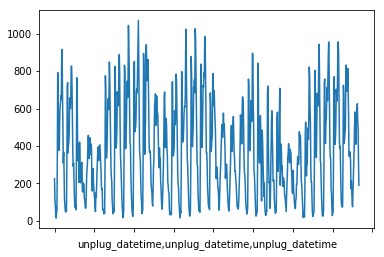

In [62]:
df.groupby([times.month, times.day, times.hour])._id.count().plot()